## Code examples

We start by importing the necessary packages

In [1]:
import numpy
import cvxpy
import scipy.stats
import matplotlib.pyplot as plt
from equilibrator_api import ComponentContribution, Q_
from numpyarray_to_latex.jupyter import to_jup

### Basic *ΔG'* calculations

Create an instance of `ComponentContribution`, which is the main interface for using eQuilibrator. This command loads all the data that is required to calculate thermodynamic potentials of reactions, and it is normal for it to take 10-20 seconds to execute.
If you are running it for the first time on a new computer, it will download a 1.3 GB file, which might take a few minutes or up to an hour (depending on your bandwidth). Don't worry, it will only happen once.

In [2]:
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

You can parse a reaction formula that uses compound accessions from different databases (KEGG, ChEBI, MetaNetX, BiGG, and a few others). The following example is ATP hydrolysis to ADP and inorganic phosphate, using BiGG metabolite IDs:

In [3]:
atpase_reaction = cc.parse_reaction_formula(
    "bigg.metabolite:atp + bigg.metabolite:h2o = "
    "bigg.metabolite:adp + bigg.metabolite:pi"
)

We highly recommend that you check that the reaction is atomically balanced (conserves atoms) and charge balanced (redox neutral). We’ve found that it’s easy to accidentally write unbalanced reactions in this format (e.g. forgetting to balance water is a common mistake) and so we always check ourselves.

In [4]:
print("The reaction is " + ("" if atpase_reaction.is_balanced() else "not ") + "balanced")    

The reaction is balanced


Now we know that the reaction is "kosher" and we can safely proceed to calculate the standard change in Gibbs potential due to this reaction.

In [5]:
dG0_prime = cc.standard_dg_prime(atpase_reaction)
print(f"ΔG'° = {dG0_prime}")

dGm_prime = cc.physiological_dg_prime(atpase_reaction)
print(f"ΔG'm = {dGm_prime}")

atpase_reaction.set_abundance(cc.get_compound("bigg.metabolite:atp"), Q_("1 mM"))
atpase_reaction.set_abundance(cc.get_compound("bigg.metabolite:adp"), Q_("100 uM"))
atpase_reaction.set_abundance(cc.get_compound("bigg.metabolite:pi"), Q_("0.003 M"))

dG_prime = cc.dg_prime(atpase_reaction)
print(f"ΔG' = {dG_prime}")

ΔG'° = (-29.14 +/- 0.30) kilojoule / mole
ΔG'm = (-46.26 +/- 0.30) kilojoule / mole
ΔG' = (-49.24 +/- 0.30) kilojoule / mole


The return values are `pint.Measurement` objects. If you want to extract the Gibbs energy value and error as floats, you can use the following commands:

In [6]:
dG_prime_value_in_kj_per_mol = dG_prime.value.m_as("kJ/mol")
dG_prime_error_in_kj_per_mol = dG_prime.error.m_as("kJ/mol")
print(
    f"ΔG'° = {dG_prime_value_in_kj_per_mol:.1f} +/- "
    f"{dG_prime_error_in_kj_per_mol:.1f} kJ/mol"
)

ΔG'° = -49.2 +/- 0.3 kJ/mol


### The reversibility index

You can also calculate the reversibility index for this reaction.

In [7]:
print(f"ln(Reversibility Index) = {cc.ln_reversibility_index(atpase_reaction)}")

ln(Reversibility Index) = (-12.45 +/- 0.08) dimensionless


The reversibility index is a measure of the degree of the reversibility of the reaction that is normalized for stoichiometry. If you are interested in assigning reversibility to reactions we recommend this measure because 1:2 reactions are much “easier” to reverse than reactions with 1:1 or 2:2 reactions. You can see [our paper](https://pubmed.ncbi.nlm.nih.gov/22645166/) for more information.

### Further examples for reaction parsing



Parsing reaction with non-trivial stoichiometric coefficients is simple. Just add the coefficients before each compound ID (if none is given, it is assumed to be 1)

In [8]:
rubisco_reaction = cc.parse_reaction_formula(
    "bigg.metabolite:rb15bp + bigg.metabolite:co2 + bigg.metabolite:h2o = 2 bigg.metabolite:3pg"
)
dG0_prime = cc.standard_dg_prime(rubisco_reaction)
print(f"ΔG'° = {dG0_prime}")

ΔG'° = (-31 +/- 4) kilojoule / mole


We support several compound databases, not just BiGG. One can mix between several sources in the same reaction, e.g.:

In [9]:
atpase_reaction = cc.parse_reaction_formula(
    "bigg.metabolite:atp + CHEBI:15377 = metanetx.chemical:MNXM7 + bigg.metabolite:pi"
)
dG0_prime = cc.standard_dg_prime(atpase_reaction)
print(f"ΔG'° = {dG0_prime}")

ΔG'° = (-29.14 +/- 0.30) kilojoule / mole


Or, you can use compound names instead of identifiers. However, it is discouraged to use in batch, since we only pick the closest hit in our database, and that can often be the wrong compound. Always verify that the reaction is balanced, and preferably also that the InChIKeys are correct:

In [10]:
glucose_isomerase_reaction = cc.search_reaction("beta-D-glucose = glucose")
for cpd, coeff in glucose_isomerase_reaction.items():
    print(f"{coeff:5.0f}  {cpd.get_common_name():15s} {cpd.inchi_key}")
dG0_prime = cc.standard_dg_prime(glucose_isomerase_reaction)
print(f"ΔG'° = {dG0_prime}")

   -1  BETA-D-GLUCOSE  WQZGKKKJIJFFOK-VFUOTHLCSA-N
    1  D-Glucose       WQZGKKKJIJFFOK-GASJEMHNSA-N
ΔG'° = (-1.6 +/- 1.3) kilojoule / mole


In this case, the matcher arbitrarily chooses $\alpha$-D-glucose as the first hit for the name `glucose`. Therefore, it is always better to use the most specific synonym to avoid mis-annotations.

### *ΔG'°* of ATP hydrolysis

as a function of pH and pMg

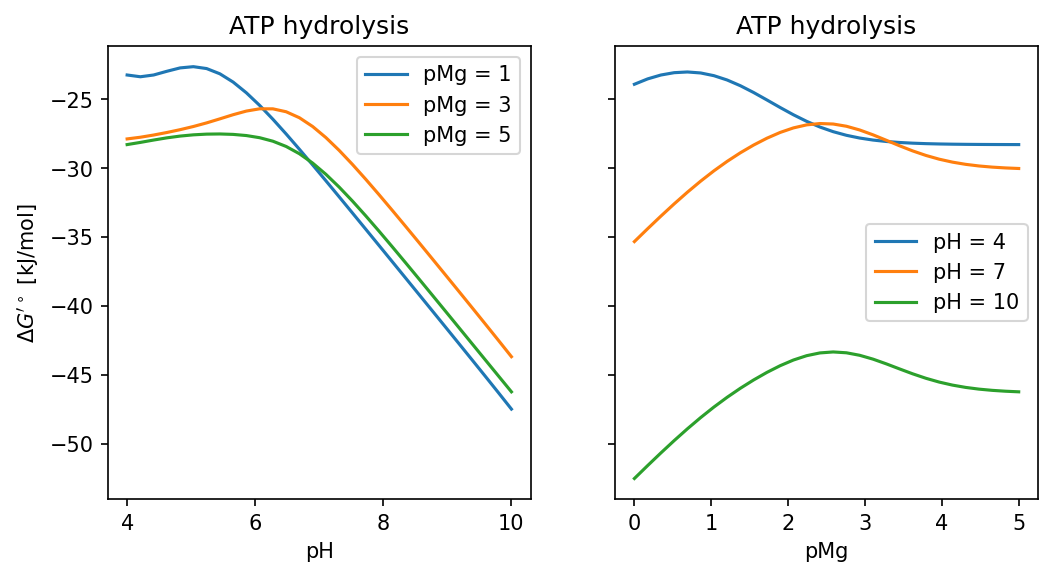

In [11]:
def calc_dg(p_h, p_mg):
    cc.p_h = Q_(p_h)
    cc.p_mg = Q_(p_mg)
    return cc.standard_dg_prime(atpase_reaction).value.m_as("kJ/mol")

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)

ax = axs[0]
ph_range = numpy.linspace(4, 10, 30)
ax.plot(ph_range, [calc_dg(p_h, 1) for p_h in ph_range], '-', label="pMg = 1")
ax.plot(ph_range, [calc_dg(p_h, 3) for p_h in ph_range], '-', label="pMg = 3")
ax.plot(ph_range, [calc_dg(p_h, 5) for p_h in ph_range], '-', label="pMg = 5")
ax.set_xlabel('pH')
ax.set_ylabel(r"$\Delta G'^\circ$ [kJ/mol]")
ax.set_title("ATP hydrolysis")
ax.legend();

ax = axs[1]
pmg_range = numpy.linspace(0, 5, 30)
ax.plot(pmg_range, [calc_dg(4, p_mg) for p_mg in pmg_range], '-', label="pH = 4")
ax.plot(pmg_range, [calc_dg(7, p_mg) for p_mg in pmg_range], '-', label="pH = 7")
ax.plot(pmg_range, [calc_dg(10, p_mg) for p_mg in pmg_range], '-', label="pH = 10")
ax.set_xlabel('pMg')
ax.set_title("ATP hydrolysis")
ax.legend();

# don't forget to change the aqueous conditions back to the default ones
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

### Multivariate calculations

We start by defining a toy model consisting of two reactions: a GTP hydrolysis reaction (NTP3) and adenylate kinase with GTP (ADK3)

In [12]:
NTP3 = cc.parse_reaction_formula(
    "bigg.metabolite:gtp + bigg.metabolite:h2o = bigg.metabolite:gdp + bigg.metabolite:pi"
)
ADK3 = cc.parse_reaction_formula(
    "bigg.metabolite:adp + bigg.metabolite:gdp = bigg.metabolite:amp + bigg.metabolite:gtp"
)

reactions = [NTP3, ADK3]

Now we use `standard_dg_prime_multi` to obtain the mean and covariance matrix of the standard ΔG' values. The covariance is represented by the full-rank square root $\mathbf{Q}$ (i.e. such that the covariance is given by $\mathbf{Q} \mathbf{Q}^\top$)

In [13]:
standard_dgr_prime_mean, standard_dgr_Q = cc.standard_dg_prime_multi(
    reactions,
    uncertainty_representation="fullrank"
)

print(f"mean (μ) in kJ / mol:")
to_jup(standard_dgr_prime_mean.m_as("kJ/mol"))
print(f"square root (Q) in kJ / mol:")
to_jup(standard_dgr_Q.m_as("kJ/mol"))
print(f"covariance in (kJ / mol)^2:")
to_jup((standard_dgr_Q @ standard_dgr_Q.T).m_as("kJ**2/mol**2"))

mean (μ) in kJ / mol:


<IPython.core.display.Math object>

square root (Q) in kJ / mol:


<IPython.core.display.Math object>

covariance in (kJ / mol)^2:


<IPython.core.display.Math object>

#### Random sampling

The following example demonstrates how one can sample from the multivariate distribution of the standard ΔG' by drawing random normal samples $\mathbf{m}$ and using $\mu$ and $\mathbf{Q}$.

$\mathbf{m} \sim \mathcal{N}(0, \mathbf{I})$

$\Delta_{r}G'^{\circ} = \mu + \mathbf{Q}~\mathbf{m}$

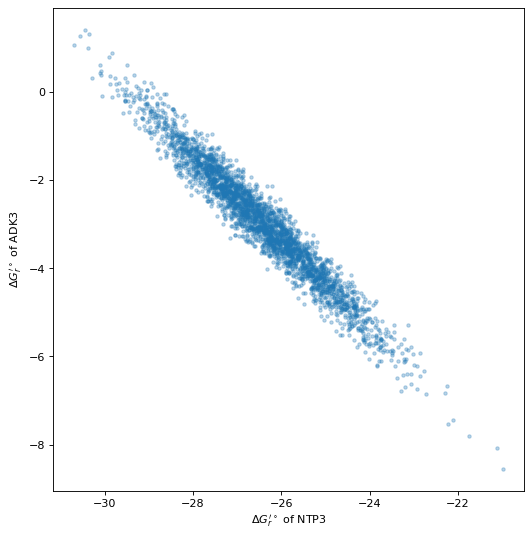

In [14]:
numpy.random.seed(2019)
N = 3000
sampled_data = []
for i in range(N):
    m = numpy.random.randn(standard_dgr_Q.shape[1])
    standard_dgr_prime_sample = standard_dgr_prime_mean + standard_dgr_Q @ m
    sampled_data.append(standard_dgr_prime_sample.m_as("kJ/mol"))
sampled_data = numpy.array(sampled_data)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=80)
ax.plot(sampled_data[:, 0], sampled_data[:, 1], '.', alpha=0.3)
ax.set_xlabel("$\Delta G_r'^\circ$ of NTP3")
ax.set_ylabel("$\Delta G_r'^\circ$ of ADK3");
ax.set_aspect("equal")

#### Constraint-based modeling

In this example, we use $\mu$ and $\mathbf{Q}$ in a quadratic constraints linear problem to find the metabolite concentrations that possible range of the total driving force (for both NTP3 and ADK3 combined).

$$
\begin{align}
    \text{maximize/minimize} & ~~~\mathbf{g}^\top \cdot \mathbf{1} \\
    \text{such that} &\\
    &\ln(10^{-4}) \leq \mathbf{x} \\
    &\mathbf{x} \leq \ln(10^{-2}) \\
    &||\mathbf{m}||_2 \leq \chi^2_{\alpha;q} \\
    &\mathbf{g} = -\mu - RT \cdot \mathbf{S}^\top \mathbf{x} - \mathbf{Q}~\mathbf{m}
    \end{align}
$$

where the desired confidence is $\alpha$ = 0.95, $\mathbf{x}$ represents the vector of metabolite log concentrations, and $\mathbf{g}$ represents vector of reaction driving forces.

In [15]:
S = cc.create_stoichiometric_matrix(reactions)

alpha = 0.95
Nc, Nr = S.shape
Nq = standard_dgr_Q.shape[1]
lb = 1e-4
ub = 1e-2

ln_conc = cvxpy.Variable(shape=Nc, name="metabolite log concentration")
m = cvxpy.Variable(shape=Nq, name="covariance degrees of freedom")

constraints = [
    numpy.log(numpy.ones(Nc) * lb) <= ln_conc,  # lower bound on concentrations
    ln_conc <= numpy.log(numpy.ones(Nc) * ub),  # upper bound on concentrations
    cvxpy.norm2(m) <= scipy.stats.chi2.ppf(alpha, Nq) ** (0.5)  # quadratic bound on m based on confidence interval
]

dg_prime = -(
    standard_dgr_prime_mean.m_as("kJ/mol") + 
    cc.RT.m_as("kJ/mol") * S.values.T @ ln_conc + 
    standard_dgr_Q.m_as("kJ/mol") @ m
)

prob_max = cvxpy.Problem(cvxpy.Maximize(dg_prime @ numpy.ones(Nr)), constraints)
prob_max.solve()
max_df = prob_max.value

prob_min = cvxpy.Problem(cvxpy.Minimize(dg_prime @ numpy.ones(Nr)), constraints)
prob_min.solve()
min_df = prob_min.value

print(f"* Possible Range of total driving force for NTP3 + ADK3: {min_df:.1f} - {max_df:.1f} kJ/mol")

* Possible Range of total driving force for NTP3 + ADK3: 5.8 - 53.0 kJ/mol




### Using formation energies to calculate reaction energies

<div class="alert alert-info">
Warning: using formation energies is highly discouraged
    
Avoid using formation energies, unless it is absolutely necessary. The function `standard_dg_formation` is difficult to use by design and requires good knowledge of thermodynamics. Please use `standard_dg_prime` instead whenever possible.
</div>

In the following example, we consider two reactions that share several reactants: ATPase and adenylate kinase

In [16]:
metabolite_names = ["atp", "adp", "amp", "pi", "h2o"]
print("order of compounds: " + str(metabolite_names) + "\n")

# obtain a list of compound objects using `get_compound`
compound_list = [cc.get_compound(f"bigg.metabolite:{cname}") for cname in metabolite_names]

# appply standard_dg_formation on each one, and pool the results in 3 lists
standard_dgf_mu, sigmas_fin, sigmas_inf = zip(*map(cc.standard_dg_formation, compound_list))
standard_dgf_mu = numpy.array(standard_dgf_mu)
sigmas_fin = numpy.array(sigmas_fin)
sigmas_inf = numpy.array(sigmas_inf)

# we now apply the Legendre transform to convert from the standard ΔGf to the standard ΔG'f
delta_dgf_list = numpy.array([
    cpd.transform(cc.p_h, cc.ionic_strength, cc.temperature, cc.p_mg).m_as("kJ/mol")
    for cpd in compound_list
])
standard_dgf_prime_mu = standard_dgf_mu + delta_dgf_list

# to create the formation energy covariance matrix, we need to combine the two outputs
# sigma_fin and sigma_inf
standard_dgf_cov = sigmas_fin @ sigmas_fin.T + 1e6 * sigmas_inf @ sigmas_inf.T

print("μ(ΔGf'0) in kJ / mol:")
to_jup(standard_dgf_prime_mu)
print("Σ(ΔGf'0) in kJ^2 / mol^2:")
to_jup(standard_dgf_cov)

order of compounds: ['atp', 'adp', 'amp', 'pi', 'h2o']

μ(ΔGf'0) in kJ / mol:


<IPython.core.display.Math object>

Σ(ΔGf'0) in kJ^2 / mol^2:


<IPython.core.display.Math object>

Now we define `S` and use it to calculate the reaction ΔG'0 values

In [17]:
S = numpy.array([
    [-1, 1, 0, 1, -1],  # ATPase
    [-1, 2, -1, 0, 0]   # adenylate kinase
], dtype=int).T
print("stoichiometric matrix:")
to_jup(S, fmt="{:d}")

standard_dgr_prime_mu = S.T @ standard_dgf_prime_mu
standard_dgr_cov = S.T @ standard_dgf_cov @ S
print(f"μ(ΔGr'0) in kJ / mol:")
to_jup(standard_dgr_prime_mu, fmt="{:.1f}")
print(f"Σ(ΔGr'0) in kJ^2 / mol^2:")
to_jup(standard_dgr_cov, fmt="{:.3f}")

stoichiometric matrix:


<IPython.core.display.Math object>

μ(ΔGr'0) in kJ / mol:


<IPython.core.display.Math object>

Σ(ΔGr'0) in kJ^2 / mol^2:


<IPython.core.display.Math object>

Compare this result to the output of `standard_dg_multi` and confirm that they are the same

In [18]:
ADK = cc.parse_reaction_formula(
    "bigg.metabolite:atp + bigg.metabolite:amp = 2 bigg.metabolite:adp"
)
standard_dgr_prime_mu2, standard_dgr_cov2 = cc.standard_dg_prime_multi([atpase_reaction, ADK])

print(f"μ(ΔGr'0) in kJ / mol:")
to_jup(standard_dgr_prime_mu2.m_as("kJ/mol"), fmt="{:.1f}")
print(f"Σ(ΔGr'0) in kJ^2 / mol^2:")
to_jup(standard_dgr_cov2.m_as("kJ**2/mol**2"), fmt="{:.3f}")

μ(ΔGr'0) in kJ / mol:


<IPython.core.display.Math object>

Σ(ΔGr'0) in kJ^2 / mol^2:


<IPython.core.display.Math object>

### Estimating energies for multi-compartment reactions

Our first example is for showing how to use `multicompartmental_standard_dg_prime` for a single reaction.

In [27]:
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

periplasmic_p_h = Q_(6.5)
periplasmic_ionic_strength = Q_("200 mM")
periplasmic_p_mg = Q_(3.0)
e_potential_difference = Q_(0.17, "V")

cytoplasmic_reaction = f"bigg.metabolite:adp + bigg.metabolite:pi + 3 bigg.metabolite:h = bigg.metabolite:h2o + bigg.metabolite:atp"
periplasmic_reaction = f"= 3 bigg.metabolite:h"
standard_dg_prime = cc.multicompartmental_standard_dg_prime(
    reaction_inner=cc.parse_reaction_formula(cytoplasmic_reaction),
    reaction_outer=cc.parse_reaction_formula(periplasmic_reaction),
    e_potential_difference=e_potential_difference,
    p_h_outer=periplasmic_p_h,
    ionic_strength_outer=periplasmic_ionic_strength,
    p_mg_outer=periplasmic_p_mg
)
print("ΔG' = ", standard_dg_prime)

ΔG' =  (-4.66 +/- 0.30) kilojoule / mole


The following example demonstrated how to use `multi_compartmental_standard_dg_prime` for estimating the standard ΔG' of the phosphotransferase (PTS) system which imports glucose into the cell while phosphorylating it using PEP. We compare the response to the number of extra transported protons, in several physiological conditions.

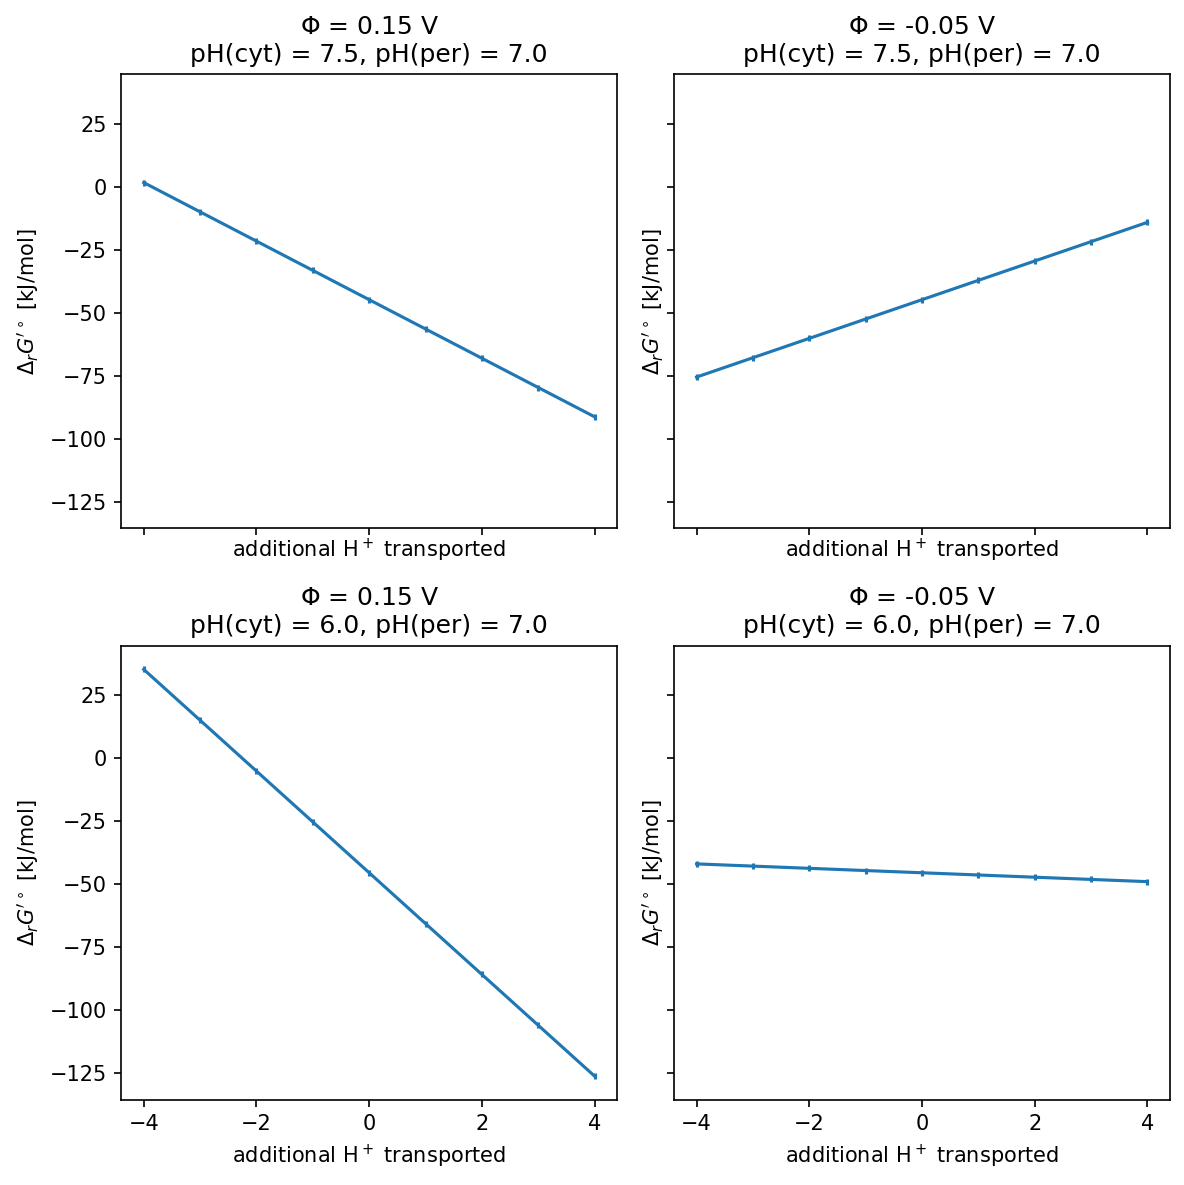

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150, sharey=True, sharex=True)

PMF_RANGE = 4
for (psi, ph), ax in zip([(0.15, 7.5), (-0.05, 7.5), (0.15, 6.0), (-0.05, 6.0)], axs.flat):
    e_potential_difference = Q_(psi, "V")

    cytoplasmic_p_h = Q_(ph)
    cytoplasmic_ionic_strength = Q_("250 mM")
    cytoplasmic_p_mg = Q_(3.0)

    periplasmic_p_h = Q_(7.0)
    periplasmic_ionic_strength = Q_("200 mM")
    periplasmic_p_mg = Q_(3.0)

    data = []
    for n_pmf in numpy.arange(-PMF_RANGE, PMF_RANGE+1):

        cytoplasmic_reaction = f"bigg.metabolite:pep + {n_pmf} bigg.metabolite:h = bigg.metabolite:g6p + bigg.metabolite:pyr"
        periplasmic_reaction = f"bigg.metabolite:glc__D = {n_pmf} bigg.metabolite:h"

        cc.p_h = cytoplasmic_p_h
        cc.ionic_strength = cytoplasmic_ionic_strength
        cc.p_mg = cytoplasmic_p_mg

        standard_dg_prime = cc.multicompartmental_standard_dg_prime(
            reaction_inner=cc.parse_reaction_formula(cytoplasmic_reaction),
            reaction_outer=cc.parse_reaction_formula(periplasmic_reaction),
            e_potential_difference=e_potential_difference,
            p_h_outer=periplasmic_p_h,
            ionic_strength_outer=periplasmic_ionic_strength,
            p_mg_outer=periplasmic_p_mg
        )
        data.append((n_pmf, standard_dg_prime.value.m_as("kJ/mol"), 1.96 * standard_dg_prime.error.m_as("kJ/mol")))

    pmf, dg, dg_conf_interval = zip(*data)
    ax.errorbar(pmf, dg, yerr=dg_conf_interval)
    ax.set_title(f"$\Phi$ = {psi} V\npH(cyt) = {cytoplasmic_p_h.m_as('')}, pH(per) = {periplasmic_p_h.m_as('')}")
    ax.set_xlabel("additional H$^+$ transported")
    ax.set_ylabel("$\Delta_r G'^\circ$ [kJ/mol]")
fig.tight_layout()

In the next example, we estimate the standard ΔG' of ATP synthase as a function of the number of extra transported protons, in either Φ = 0.14V and Φ = 0.17V.

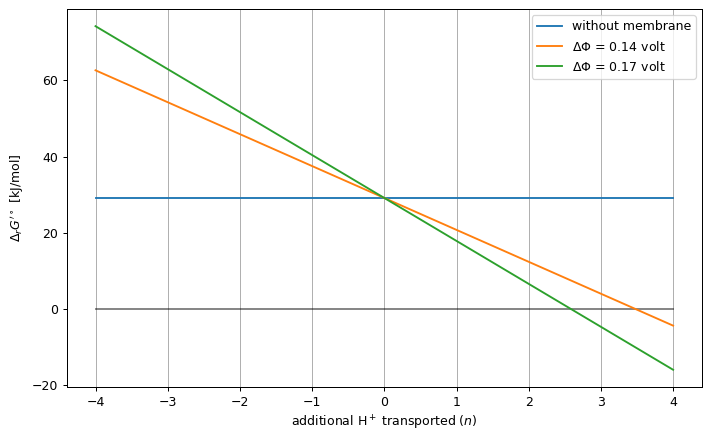

In [21]:
data_series = []
PMF_RANGE = 4
cc.p_h = Q_(7.4) # set the cytoplasmic pH
cc.ionic_strength = Q_("250 mM") # set the cytoplasmic I
cc.p_mg = Q_(3.0) # set the cytoplasmic pMg
periplasmic_p_h = Q_(6.5)
periplasmic_ionic_strength = Q_("200 mM")
periplasmic_p_mg = Q_(3.0)
for phi in [0.14, 0.17]:
    e_potential_difference = Q_(phi, "V")
    data = []
    for n_pmf in numpy.arange(-PMF_RANGE, PMF_RANGE+1):
        cytoplasmic_reaction = (
            f"bigg.metabolite:adp + bigg.metabolite:pi + {n_pmf} bigg.metabolite:h = "
            "bigg.metabolite:h2o + bigg.metabolite:atp"
        )
        periplasmic_reaction = f" = {n_pmf} bigg.metabolite:h"
        standard_dg_prime = cc.multicompartmental_standard_dg_prime(
            reaction_inner=cc.parse_reaction_formula(cytoplasmic_reaction),
            reaction_outer=cc.parse_reaction_formula(periplasmic_reaction),
            e_potential_difference=e_potential_difference,
            p_h_outer=periplasmic_p_h,
            ionic_strength_outer=periplasmic_ionic_strength,
            p_mg_outer=periplasmic_p_mg
        )
        data.append((n_pmf, standard_dg_prime.value.m_as("kJ/mol")))
    pmf, dg = zip(*data)
    data_series.append((
        e_potential_difference, cytoplasmic_p_h, periplasmic_p_h, pmf, dg
    ))
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=90, sharey=True, sharex=True)
dG0_prime = -cc.standard_dg_prime(atpase_reaction).value.m_as("kJ/mol")
ax.plot([-PMF_RANGE, PMF_RANGE], [dG0_prime, dG0_prime],
        label="without membrane")
ax.plot([-PMF_RANGE, PMF_RANGE], [0, 0], "k-", alpha=0.5, label=None)
for e_potential_difference, _, _, pmf, dg in data_series:
    ax.plot(
        pmf, dg,
        label=f"$\Delta\Phi$ = {e_potential_difference}"
    )
ax.set_xlabel("additional H$^+$ transported ($n$)")
ax.set_ylabel("$\Delta_r G'^\circ$ [kJ/mol]")
ax.set_xticks(numpy.arange(-PMF_RANGE, PMF_RANGE+1))
ax.axes.xaxis.grid(True)
ax.legend(loc="best")
fig.tight_layout()
fig.savefig("pmf.pdf")